# Inference 

In [1]:
using Distributions
using TikzPictures
using PGFPlots
using BayesNets

INFO: Recompiling stale cache file U:\.julia\lib\v0.5\BayesNets.ji for module BayesNets.


# Inference for Classification

In [2]:
b = BayesNet()

In [3]:
# Set uniform prior over Class
push!(b, StaticCPD(:Class, NamedCategorical(["bird", "aircraft"], [0.5, 0.5])))

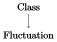

In [4]:
fluctuationStates = ["low", "hi"]
fluctuationDistributions(a::Assignment) = a[:Class] == "bird" ? NamedCategorical(fluctuationStates, [0.1, 0.9]) : 
                                                                NamedCategorical(fluctuationStates, [0.9, 0.1])
push!(b, FunctionalCPD{NamedCategorical}(:Fluctuation, [:Class], fluctuationDistributions))

In [5]:
# Function for plotting CPDs (don't worry about details here)
function plotCPD(cpd::CPD, range::Tuple{Real,Real}, assignments)
    convertAssignmentToString(a) = string(["$k = $v, " for (k,v) in a]...)[1:end-2]
    Axis(Plots.Plot[Plots.Linear(x->pdf(cpd(a), x), range, legendentry=convertAssignmentToString(a)) for a in assignments], width="25cm", height="8cm")
end;

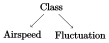

In [6]:
# if Bird, then Airspeed ~ N(45,10)
# if Aircraft, then Airspeed ~ N(100,40)
airspeedDistributions(a::Assignment) = a[:Class] == "bird" ? Normal(45,10) : Normal(100,40)
push!(b, FunctionalCPD{Normal}(:Airspeed, [:Class], airspeedDistributions))

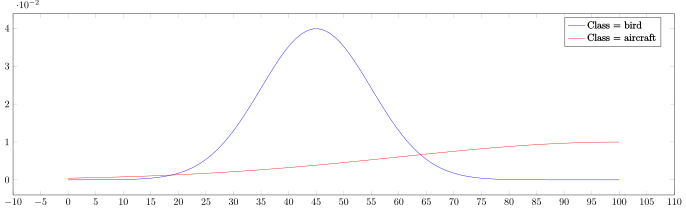

In [7]:
plotCPD(get(b, :Airspeed), (0., 100.), [Assignment(:Class=>c) for c in ["bird", "aircraft"]])

In [8]:
pb = pdf(b, :Class=>"bird", :Airspeed=>65, :Fluctuation=>"low")

0.00026995483256594033

In [9]:
pa = pdf(b, :Class=>"aircraft", :Airspeed=>65, :Fluctuation=>"low")

0.003060618731758615

In [10]:
# Probability of aircraft given data
pa / (pa + pb)

0.9189464435022358

In [11]:
# View (unnormalized) distribution as a vector
d = [pb, pa]

2-element Array{Float64,1}:
 0.000269955
 0.00306062 

In [12]:
# Now normalize
d / sum(d)

2-element Array{Float64,1}:
 0.0810536
 0.918946 

# Exact Inference

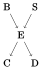

In [13]:
b = DiscreteBayesNet()
push!(b, DiscreteCPD(:B, [0.1,0.9]))
push!(b, DiscreteCPD(:S, [0.5,0.5]))
push!(b, rand_cpd(b, 2, :E, [:B, :S]))
push!(b, rand_cpd(b, 2, :D, [:E]))
push!(b, rand_cpd(b, 2, :C, [:E]))

Compute $P(b^1, d^1, c^1) = \sum_{s}\sum_{e}P(b^1)P(s)P(e|b^1, s)P(d^1|e)P(c^1|e)$

In [14]:
a = Assignment(:B=>2, :D=>2, :C=>2)

Dict{Symbol,Any} with 3 entries:
  :C => 2
  :B => 2
  :D => 2

In [15]:
T = table(b,:B,a)*table(b,:S)*table(b,:E,a)*table(b,:D,a)*table(b,:C,a)

4×6 DataFrames.DataFrame
│ Row │ B │ S │ E │ D │ C │ p           │
├─────┼───┼───┼───┼───┼───┼─────────────┤
│ 1   │ 2 │ 1 │ 1 │ 2 │ 2 │ 0.00294161  │
│ 2   │ 2 │ 2 │ 1 │ 2 │ 2 │ 0.00881713  │
│ 3   │ 2 │ 1 │ 2 │ 2 │ 2 │ 0.000327252 │
│ 4   │ 2 │ 2 │ 2 │ 2 │ 2 │ 8.585e-5    │

In [16]:
sumout(T, [:S, :E])

1×4 DataFrames.DataFrame
│ Row │ B │ D │ C │ p         │
├─────┼───┼───┼───┼───────────┤
│ 1   │ 2 │ 2 │ 2 │ 0.0121718 │

In [17]:
# Approximate Inference

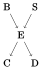

In [18]:
b = DiscreteBayesNet()
push!(b, DiscreteCPD(:B, [0.1,0.9]))
push!(b, DiscreteCPD(:S, [0.5,0.5]))
push!(b, rand_cpd(b, 2, :E, [:B, :S]))
push!(b, rand_cpd(b, 2, :D, [:E]))
push!(b, rand_cpd(b, 2, :C, [:E]))

In [19]:
rand(b)

Dict{Symbol,Any} with 5 entries:
  :S => 1
  :C => 1
  :B => 2
  :D => 2
  :E => 2

In [20]:
rand(b, 8)

8×5 DataFrames.DataFrame
│ Row │ B │ S │ E │ C │ D │
├─────┼───┼───┼───┼───┼───┤
│ 1   │ 2 │ 1 │ 2 │ 1 │ 2 │
│ 2   │ 2 │ 1 │ 2 │ 2 │ 1 │
│ 3   │ 1 │ 2 │ 2 │ 1 │ 1 │
│ 4   │ 2 │ 2 │ 2 │ 1 │ 1 │
│ 5   │ 1 │ 2 │ 1 │ 1 │ 2 │
│ 6   │ 2 │ 1 │ 2 │ 2 │ 2 │
│ 7   │ 2 │ 1 │ 1 │ 1 │ 2 │
│ 8   │ 2 │ 1 │ 2 │ 1 │ 2 │

# Example chemical detection network

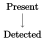

In [21]:
b = BayesNet()
push!(b, StaticCPD(:Present, Bernoulli(0.001)))
push!(b, FunctionalCPD{Bernoulli}(:Detected, [:Present], a->Bernoulli(a[:Present] == true ? 0.999 : 0.001)))

In [22]:
rand(b, 10)

10×2 DataFrames.DataFrame
│ Row │ Present │ Detected │
├─────┼─────────┼──────────┤
│ 1   │ 0       │ 0        │
│ 2   │ 0       │ 0        │
│ 3   │ 0       │ 0        │
│ 4   │ 0       │ 0        │
│ 5   │ 0       │ 0        │
│ 6   │ 0       │ 0        │
│ 7   │ 0       │ 0        │
│ 8   │ 0       │ 0        │
│ 9   │ 0       │ 0        │
│ 10  │ 0       │ 0        │

Not very interesting since all the samples are likely to be (false, false)

In [23]:
data = rand(b, 1000)
sum(data[:Detected] .== 1)

1

Even with 1000 samples, we are not likely to get many samples that are consistent with Detected = true. This can result in a pretty poor estimate.

In [24]:
estimate(rand(b, 1000, :Detected=>true, max_nsamples=100000000))

2×3 DataFrames.DataFrame
│ Row │ Present │ Detected │ p    │
├─────┼─────────┼──────────┼──────┤
│ 1   │ 0       │ 1        │ 0.49 │
│ 2   │ 1       │ 1        │ 0.51 │

# Likelihood weighted sampling

In [25]:
rand_table_weighted(b, nsamples=10, consistent_with=Assignment(:Detected=>true))

10×3 DataFrames.DataFrame
│ Row │ Detected │ Present │ p   │
├─────┼──────────┼─────────┼─────┤
│ 1   │ true     │ 0       │ 0.1 │
│ 2   │ true     │ 0       │ 0.1 │
│ 3   │ true     │ 0       │ 0.1 │
│ 4   │ true     │ 0       │ 0.1 │
│ 5   │ true     │ 0       │ 0.1 │
│ 6   │ true     │ 0       │ 0.1 │
│ 7   │ true     │ 0       │ 0.1 │
│ 8   │ true     │ 0       │ 0.1 │
│ 9   │ true     │ 0       │ 0.1 │
│ 10  │ true     │ 0       │ 0.1 │

In [26]:
estimate(rand_table_weighted(b, nsamples=10000, consistent_with=Assignment(:Detected=>true)))

2×3 DataFrames.DataFrame
│ Row │ Detected │ Present │ p        │
├─────┼──────────┼─────────┼──────────┤
│ 1   │ true     │ 0       │ 0.555605 │
│ 2   │ true     │ 1       │ 0.444395 │